This notebook contains code for replicating experiments from the paper "Uncertainty-Aware Deep Ensembles for Reliable and Explainable Predictions of Clinical Time Series" on synthetic data. Remember to enable the use of GPU to speed up computations.

The following cell installs the package used to generate the data used in this experiment. 

In [ ]:
#@title Install TimeSynth package

!pip install git+https://github.com/TimeSynth/TimeSynth.git

The following cell loads all the required packages for this experiment.



In [9]:
#@title Load packages and data

import time
import copy
import random
import torch as th
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import timesynth as ts
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from itertools import product
from matplotlib.colors import Normalize
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import  MinMaxScaler, StandardScaler, minmax_scale
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

def to_np(x):
    return x.cpu().detach().numpy()

The following cell creates the synthetic data used in this experiment.



In [ ]:
#@title Create synthetic data


time_sampler = ts.TimeSampler(stop_time=20)
irregular_time_samples = time_sampler.sample_irregular_time(num_points=500, keep_percentage=50)

sinusoid = ts.signals.Sinusoidal(frequency=0.2)
white_noise = ts.noise.GaussianNoise(std=0.5)
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
samples, signals, errors = timeseries.sample(irregular_time_samples)

x_tr = np.zeros((500, 1, 250))
x_te = np.zeros((500, 1, 250))

y_tr = np.concatenate((np.zeros((250), dtype=np.int32), np.ones((250), dtype=np.int32)))
y_te = np.concatenate((np.zeros((250), dtype=np.int32), np.ones((250), dtype=np.int32)))

r_tr = np.zeros((500, 9), dtype=np.int32)
r_te = np.zeros((500, 9), dtype=np.int32)

for i in range(250):

    r_idx = np.random.randint(50, 200, 1)[0]
    r_tr[i, 1:6] = [r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2]
    x_i, signals, errors = timeseries.sample(irregular_time_samples)
    x_i[r_tr[i, 1:6]] += 2
    r_tr[i] = [r_idx-4, r_idx-3, r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2, r_idx+3, r_idx+4]
    x_tr[i, 0] = x_i


for i in range(250, 500):

    r_idx = np.random.randint(50, 200, 1)[0]
    r_tr[i, 1:6] = [r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2]
    x_i, signals, errors = timeseries.sample(irregular_time_samples)
    x_i[r_tr[i, 1:6]] -= 2
    r_tr[i] = [r_idx-4, r_idx-3, r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2, r_idx+3, r_idx+4]
    x_tr[i, 0] = x_i


for i in range(250):

    r_idx = np.random.randint(50, 200, 1)[0]
    r_te[i, 1:6] = [r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2]
    x_i, signals, errors = timeseries.sample(irregular_time_samples)
    x_i[r_te[i, 1:6]] += 2
    r_te[i] = [r_idx-4, r_idx-3, r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2, r_idx+3, r_idx+4]
    x_te[i, 0] = x_i


for i in range(250, 500):

    r_idx = np.random.randint(50, 200, 1)[0]
    r_te[i, 1:6] = [r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2]
    x_i, signals, errors = timeseries.sample(irregular_time_samples)
    x_i[r_te[i, 1:6]] -= 2
    r_te[i] = [r_idx-4, r_idx-3, r_idx-2, r_idx-1, r_idx, r_idx+1, r_idx+2, r_idx+3, r_idx+4]
    x_te[i, 0] = x_i


The following cell creates a Pytorch dataset from the synthetic data for easier loading and handling of the data. For simplicty, we generate the data once and use it throught the experiments. However, to get a more robust evaluation of performance the data generation can be moved inside the training loop in the "Experiment" block.



In [4]:
#@title Create dataset

class TSDatasetSupervised(Dataset):
    def __init__(self, split, device='cuda'):

        self.device = device

        if split == 'TRAIN':
            self.x = th.tensor(x_tr, dtype=th.float, device=device)
            self.y = th.tensor(y_tr, dtype=th.long, device=device)
        if split == 'TEST':
            self.x = th.tensor(x_te, dtype=th.float, device=device)
            self.y = th.tensor(y_te, dtype=th.long, device=device)

        self.n_c = 2

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):      
        return self.x[idx], self.y[idx]


The following cell creates the class for the convolutional neural network used in this experiment. The model is based on the fully convolutional network of Want et.al.: [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).



In [5]:
#@title Define CNN

class CNN(nn.Module):
    def __init__(self, n_in, n_c):
        super(CNN, self).__init__()

        n_hid = 128
        act = nn.ReLU()

        self.l1 = nn.Sequential(
            nn.Conv1d(n_in, n_hid, kernel_size=7, padding=3),
            nn.BatchNorm1d(n_hid),
            act
        )

        self.l2 = nn.Sequential(
            nn.Conv1d(n_hid, 2*n_hid, kernel_size=5, padding=2),
            nn.BatchNorm1d(2*n_hid),
            act
        )

        self.l3 = nn.Sequential(
            nn.Conv1d(2*n_hid, n_hid, kernel_size=3, padding=1),
            nn.BatchNorm1d(n_hid),
            act
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.out = nn.Linear(n_hid, n_c)

    def forward(self, x):

        l1 = self.l1(x)
        l2 = self.l2(l1)
        l3 = self.l3(l2)

        gap = self.gap(l3)
        out = self.out(gap)

        return out

    def CAM(self, x):
 
        l1 = self.l1(x)
        l2 = self.l2(l1)
        l3 = self.l3(l2)

        out = th.matmul(l3.transpose(2, 1), self.out.weight.T)
        out = nn.functional.relu(out)
        out = out.cpu().detach().numpy()

        return out



The following cell creates function that are used throughout the rest of the code.



In [6]:
#@title Define some useful functions

def calc_metrics(y, y_hat):

    TN, FP, FN, TP = confusion_matrix(y, y_hat).ravel()

    precision = TP / (TP+FP)
    FallOut = FP / (FP+TN)
    recall = TP / (TP+FN)
    NPV = TN / (TN+FN)

    return [precision, recall, NPV, FallOut]


def get_ensemble_pred(x, model_list):

    for model_idx, model in enumerate(model_list):
        out = model(xte)
        if model_idx == 0: y_hat = to_np(th.nn.functional.softmax(out, dim=1))
        else: y_hat += to_np(th.nn.functional.softmax(out, dim=1))

    y_hat = y_hat / len(model_list)

    return y_hat

The following cell traings the single model and the ensemble model. In this code, "M" denotes the number of models in the ensemble, and "num_repeats" denotes the number of times the experiments will be repeated. This is set to 1 here, but in the paper we do 10 independet training runs.



In [ ]:
#@title Experiment

metrics_list = []
ensemble_metrics_list = []

M, num_repeats = 10, 1
model_list = []


training_set = TSDatasetSupervised('TRAIN')
test_set = TSDatasetSupervised('TEST')

batch_size_tr = len(training_set.x)
batch_size_te = len(test_set.x)

training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                shuffle=True, drop_last=False)
test_generator = DataLoader(test_set, batch_size= batch_size_te,
                                shuffle=True, drop_last=False)

for run in range(num_repeats):
    for m in range(M):

        print(f"Model number {m}")

        model = CNN(training_set.x.shape[1], training_set.n_c).to('cuda')
        criterion = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters())

        LossList, AccList, epochs = [], [], 150

        for i in range(epochs):
            for xtr, ytr in training_generator:

                model.train()
                optimizer.zero_grad()

                xtr = xtr.to('cuda')
                out = model(xtr)

                loss = criterion(out, ytr)
                loss.backward()
                LossList.append(loss.item())
                optimizer.step()

            with th.no_grad():
                model.eval()
                for xte, yte in test_generator:

                    out = model(xte)
                    y_hat = th.argmax(out, 1)
                    accuracy = th.eq(yte, y_hat).sum().float() / len(xte)
                    AccList.append(accuracy.item())

        model_list.append(copy.deepcopy(model))
        metrics_list.append(calc_metrics(to_np(yte), to_np(y_hat)))
        print(metrics_list[-1])

    y_hat_ensemble = get_ensemble_pred(xte, model_list)
    ensemble_metrics_list.append(calc_metrics(to_np(yte), y_hat_ensemble.argmax(1)))
    print(ensemble_metrics_list[-1])


The following cell makes a prediction for a random sample in the test data and plots the time steps that are most relevant for the prediction, and the uncertainty of the relevance scores.



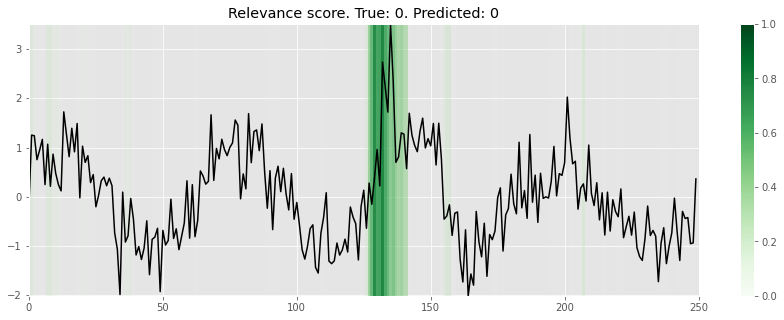

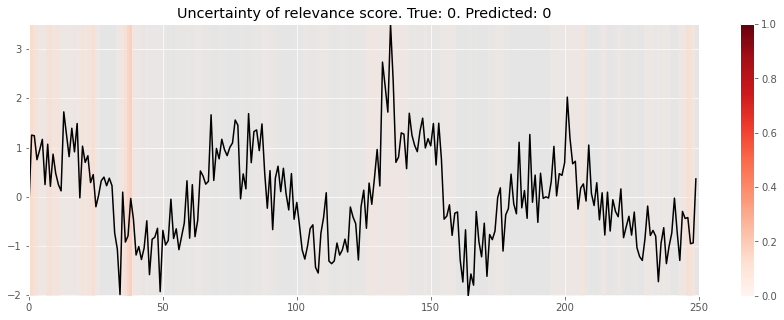

In [22]:
#@title CAM illustration


model.eval()
N, T = test_set.x.shape[0], test_set.x.shape[-1]
sample = np.random.choice(list(np.arange(0, N, 1)), 1)[0]

my_cmap_mean = cm.get_cmap('Greens')
my_cmap_std = cm.get_cmap('Reds')
sm_mean = plt.cm.ScalarMappable(cmap=my_cmap_mean, norm=Normalize(vmin=0, vmax=1))
sm_std = plt.cm.ScalarMappable(cmap=my_cmap_std, norm=Normalize(vmin=0, vmax=1))

x_plot = np.arange(0, T, 1)

interpret_array =  np.array([model.CAM(test_set.x) for model in model_list])
interpret_array = interpret_array / (interpret_array.max(1, keepdims=True)+1.e-8)

interpret_mean = interpret_array.mean(0)
interpret_std = interpret_array.std(0)

pred = get_ensemble_pred(test_set.x, model_list).argmax(1)
y_samp = to_np(test_set.y[sample])
pred_samp = pred[sample]

scale_col_mean = np.abs(interpret_mean[sample, :, pred_samp] / (np.abs(interpret_mean[sample, :, pred_samp]).max())).reshape(T, 1)
color_weight_mean = np.ones((T, 3))
color_weight_mean = np.concatenate((color_weight_mean, scale_col_mean), 1)
plot_col_mean = my_cmap_mean(interpret_mean[sample, :, pred_samp])*color_weight_mean

plt.figure(1, figsize=(15, 5))
plt.plot(x_plot, to_np(test_set.x[sample])[0], color='black')
plt.bar(x_plot, 200*np.ones_like(x_plot), bottom=-100, width=1.0,
        color=plot_col_mean)
plt.xlim(0, T)
plt.ylim(to_np(test_set.x[sample])[0].min(), to_np(test_set.x[sample])[0].max())
plt.title(f"Mean relevance score. True: {y_samp}. Predicted: {pred_samp}")
plt.show()

scale_col_std = np.abs(interpret_std[sample, :, pred_samp] / (np.abs(interpret_std[sample, :, pred_samp]).max())).reshape(T, 1)
color_weight_std = np.ones((T, 3))
color_weight_std = np.concatenate((color_weight_std, scale_col_std), 1)
plot_col_std = my_cmap_std(interpret_std[sample, :, pred_samp])*color_weight_std

plt.figure(2, figsize=(15, 5))
plt.plot(x_plot, to_np(test_set.x[sample])[0], color='black')
plt.bar(x_plot, 200*np.ones_like(x_plot), bottom=-100, width=1.0,
        color=plot_col_std)
plt.xlim(0, T)
plt.ylim(to_np(test_set.x[sample])[0].min(), to_np(test_set.x[sample])[0].max())
plt.title(f"Uncertainty of relevance score. True: {y_samp}. Predicted: {pred_samp}")
plt.show()

filtered_time_steps = (scale_col_std.squeeze() < scale_col_std.squeeze().mean())*1.0
scale_col_filtered = np.reshape(scale_col_mean.squeeze() * filtered_time_steps, (T, 1))
color_weight_filtered = np.ones((T, 3))
color_weight_filtered = np.concatenate((color_weight_filtered, scale_col_filtered), 1)
plot_col_filtered = my_cmap_mean(interpret_mean[sample, :, pred_samp])*color_weight_filtered


plt.figure(3, figsize=(15, 5))
plt.plot(x_plot, to_np(test_set.x[sample])[0], color='black')
plt.bar(x_plot, 200*np.ones_like(x_plot), bottom=-100, width=1.0,
        color=plot_col_filtered)
plt.xlim(0, T)
plt.ylim(to_np(test_set.x[sample])[0].min(), to_np(test_set.x[sample])[0].max())
plt.title(f"Uncertainty filtered mean relevance score. True: {y_samp}. Predicted: {pred_samp}")
plt.show()

The following cell computes the relevance score accuracy for single and ensemble model, using the know relevant time steps from the construction of the data. This cell takes some time to run.

In [39]:
#@title Compute relevance score accuracy over independent training runs


num_repeats, M = 10, 10
model_list, topk_list = [], [9, 10, 11, 12, 15]
single_model_scores = np.zeros((num_repeats, len(topk_list)))
ensemble_model_scores = np.zeros((num_repeats, len(topk_list)))

training_set = TSDatasetSupervised('TRAIN')
test_set = TSDatasetSupervised('TEST')

batch_size_tr = len(training_set.x)
batch_size_te = len(test_set.x)

training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                shuffle=True, drop_last=False)
test_generator = DataLoader(test_set, batch_size= batch_size_te,
                                shuffle=True, drop_last=False)


for repeat_n in range(num_repeats):

    print(f"Run number {repeat_n}")

    for m in range(M):

        print(f"Model number {m}")

        model = CNN(training_set.x.shape[1], training_set.n_c).to('cuda')
        criterion = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters())

        LossList, AccList, epochs = [], [], 150

        for i in range(epochs):
            for xtr, ytr in training_generator:

                model.train()
                optimizer.zero_grad()

                xtr = xtr.to('cuda')
                out = model(xtr)

                loss = criterion(out, ytr)
                loss.backward()
                LossList.append(loss.item())
                optimizer.step()

            with th.no_grad():
                model.eval()
                for xte, yte in test_generator:

                    out = model(xte)
                    y_hat = th.argmax(out, 1)
                    accuracy = th.eq(yte, y_hat).sum().float() / len(xte)
                    AccList.append(accuracy.item())

        model_list.append(copy.deepcopy(model))

    interpret_array = model_list[np.random.randint(0, len(model_list), 1)[0]].CAM(test_set.x)
    interpret_array = np.take_along_axis(interpret_array, to_np(test_set.y[:, None, None]), axis=2).squeeze()

    correct_rel_sum = []

    for topk_idx, topk in enumerate(topk_list):
        topk_rel_scores = interpret_array.argsort(1)[:, -topk:]
        single_model_scores[repeat_n, topk_idx] = np.mean([np.isin(r_te[n], topk_rel_scores[n]).sum() / 9 
                                                           for n in range(len(r_te))])


    interpret_array_ensemble = np.array([model.CAM(test_set.x) for model in model_list])

    interpret_array_ensemble = interpret_array_ensemble 
    interpret_array_mean = interpret_array_ensemble.mean(0)
    interpret_array_std = interpret_array_ensemble.std(0)
    interpret_array = interpret_array_mean

    interpret_array_mean = np.take_along_axis(interpret_array_mean, to_np(test_set.y[:, None, None]), axis=2).squeeze()
    interpret_array_std = np.take_along_axis(interpret_array_std, to_np(test_set.y[:, None, None]), axis=2).squeeze()
    interpret_array = np.take_along_axis(interpret_array, to_np(test_set.y[:, None, None]), axis=2).squeeze()

    correct_rel_sum = []

    for topk_idx, topk in enumerate(topk_list):
        topk_rel_scores = interpret_array.argsort(1)[:, -topk:]
        ensemble_model_scores[repeat_n, topk_idx] = np.mean([np.isin(r_te[n], topk_rel_scores[n]).sum() / 9 
                                                             for n in range(len(r_te))])

    clear_output()

print(f"Mean accuracy of single model: {single_model_scores.mean(0)}")
print(f"Mean accuracy of ensemble model: {ensemble_model_scores.mean(0)}")

Mean accuracy of single model: [0.70291111 0.76546667 0.82162222 0.86855556 0.93522222]
Mean accuracy of ensemble model: [0.73604444 0.80037778 0.85537778 0.89968889 0.95088889]


The following cell computes the consistency for single and ensemble model. This cell takes some time to run.

In [ ]:
#@title Compute consistency over independent training runs


num_repeats, M = 10, 10
topk_list = [5, 7, 10, 15]

training_set = TSDatasetSupervised('TRAIN')
test_set = TSDatasetSupervised('TEST')

batch_size_tr = len(training_set.x)
batch_size_te = len(test_set.x)

training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                shuffle=True, drop_last=False)
test_generator = DataLoader(test_set, batch_size= batch_size_te,
                                shuffle=True, drop_last=False)

single_model_rel_scores = np.zeros((num_repeats, 500, test_set.x.shape[-1]))
ensemble_model_rel_scores = np.zeros((num_repeats, 500, test_set.x.shape[-1]))

for repeat_n in range(num_repeats):

    model_list = []

    print(f"Run number {repeat_n}")

    for m in range(M):

        print(f"Model number {m}")

        model = CNN(training_set.x.shape[1], training_set.n_c).to('cuda')
        criterion = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters())

        LossList, AccList, epochs = [], [], 150

        for i in range(epochs):
            for xtr, ytr in training_generator:

                model.train()
                optimizer.zero_grad()

                xtr = xtr.to('cuda')
                out = model(xtr)

                loss = criterion(out, ytr)
                loss.backward()
                LossList.append(loss.item())
                optimizer.step()

            with th.no_grad():
                model.eval()
                for xte, yte in test_generator:

                    out = model(xte)
                    y_hat = th.argmax(out, 1)
                    accuracy = th.eq(yte, y_hat).sum().float() / len(xte)
                    AccList.append(accuracy.item())

        model_list.append(copy.deepcopy(model))

    interpret_array = model_list[np.random.randint(0, len(model_list), 1)[0]].CAM(test_set.x)
    single_model_rel_scores[repeat_n] = np.take_along_axis(interpret_array,
                                                           to_np(test_set.y[:, None, None]), axis=2).squeeze()


    interpret_array_ensemble = np.array([model.CAM(test_set.x) for model in model_list])
    interpret_array_ensemble = interpret_array_ensemble.mean(0)

    ensemble_model_rel_scores[repeat_n] = np.take_along_axis(interpret_array_ensemble,
                                                             to_np(test_set.y[:, None, None]), axis=2).squeeze()

    clear_output()

for topk_idx, topk in enumerate(topk_list):

    interpret_idx = single_model_rel_scores.argsort(2)[:, :, -topk:]
    sim_array = np.zeros((num_repeats, num_repeats))

    for i in range(num_repeats):
        for j in range(num_repeats):
            sim_array[i, j] = sum([np.isin(interpret_idx[i, n], interpret_idx[j, n]).sum() / topk for n in range(len(test_set.x))]) / len(test_set.x)

    print(f"Consistency for single model: {sim_array.mean()}")

for topk_idx, topk in enumerate(topk_list):

    interpret_idx = ensemble_model_rel_scores.argsort(2)[:, :, -topk:]
    sim_array = np.zeros((num_repeats, num_repeats))

    for i in range(num_repeats):
        for j in range(num_repeats):
            sim_array[i, j] = sum([np.isin(interpret_idx[i, n], interpret_idx[j, n]).sum() / topk for n in range(len(test_set.x))]) / len(test_set.x)

    print(f"Consistency for ensemble model: {sim_array.mean()}")

Run number 1
Model number 0
Model number 1
Model number 2
Model number 3
Model number 4
Model number 5
Model number 6
Model number 7
Model number 8
